In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages

import os
import random
import gc
import h5py

In [2]:
from datetime import datetime
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

2018/12/17 20:12:02


In [2]:
class RK_Exuz:
    def __init__(self, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt):
        self.J = J
        self.alpha = alpha
        self.tau = tau
        self.E_0_default = E_0_default
        self.t_fac = t_fac
        self.t_d = t_d
        self.t_th = t_th
        self.thre_effi = thre_effi
        self.U = U
        self.dt = dt
        self.time = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.E_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.u_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.x_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.z_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        
    def gain_function_(self, z):
        return self.alpha * math.log(1 + math.exp(z/self.alpha))

    def f_E(self, E_t, x_t, u_t, z_t):
        return (-E_t + self.gain_function_(self.J * u_t * x_t * E_t + self.E_0_default - self.thre_effi * z_t))/self.tau

    def f_x(self, E_t, x_t, u_t, z_t):
        return (1 - x_t)/self.t_d - u_t * x_t * E_t

    def f_u(self, E_t, x_t, u_t, z_t):
        return (self.U - u_t)/self.t_fac + self.U * (1 - u_t) * E_t

    def f_z(self, E_t, x_t, u_t, z_t):
        return (E_t - z_t)/self.t_th

    def RK4(self, E_t, x_t, u_t, z_t, dt, time_index_in_reset):
        # compute k1
        k1_E = self.f_E(E_t, x_t, u_t, z_t)
        k1_x = self.f_x(E_t, x_t, u_t, z_t)
        k1_u = self.f_u(E_t, x_t, u_t, z_t)
        k1_z = self.f_z(E_t, x_t, u_t, z_t)
        # compute k2
        k2_E = self.f_E(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2)
        k2_x = self.f_x(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2)
        k2_u = self.f_u(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2)
        k2_z = self.f_z(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2)
        # compute k3
        k3_E = self.f_E(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2)
        k3_x = self.f_x(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2)
        k3_u = self.f_u(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2)
        k3_z = self.f_z(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2)
        # compute k4
        k4_E = self.f_E(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt)
        k4_x = self.f_x(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt)
        k4_u = self.f_u(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt)
        k4_z = self.f_z(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt)
        # compute y_n+1
        return (E_t+(k1_E+2.*k2_E+2.*k3_E+k4_E)*dt/6.), (x_t+(k1_x+2.*k2_x+2.*k3_x+k4_x)*dt/6.), (u_t+(k1_u+2.*k2_u+2.*k3_u+k4_u)*dt/6.), (z_t+(k1_z+2.*k2_z+2.*k3_z+k4_z)*dt/6.)

    def init_dynamical_variable_and_time_with_memory_reset(self, T, E_ini, u_ini, x_ini, z_ini, memory_reset_timing):
        self.E_t[0] = E_ini
        self.u_t[0] = u_ini
        self.x_t[0] = x_ini
        self.z_t[0] = z_ini
    
    def start_simulation_with_gc(self, T, memory_reset_timing, data_dir_name='no'):
        print("starting sinulation\nsimulation time {}sec".format(int(T*self.dt)))
        print("parameters are following\ntau {} t_fac {} t_d {} t_th {} U {}".format(self.tau, self.t_fac, self.t_d, self.t_th, self.U))
        print("J {} alpha {} thre_effi {}".format(self.J, self.alpha, self.thre_effi))
        print(self.E_t[0])
        for i in range(int(T) - 1):
            time_index_in_reset = i%int(memory_reset_timing*(1/self.dt))
            if (time_index_in_reset+1 == int(memory_reset_timing*(1/self.dt))):
                if (int((i+1)%10000000)==0):
                    self.data_dump_and_reset(True, '{}/{}_{}.h5'.format(data_dir_name, int((i+1)*self.dt) - memory_reset_timing, int((i+1)*self.dt)))
                else:
                    self.data_dump_and_reset()
            else:
                self.time[time_index_in_reset+1] = (time_index_in_reset+1) * self.dt
                #self.time[time_index_in_reset+1] = (i+1) * self.dt
                if time_index_in_reset == 0:
                    print("resetted i {}".format(int(i*self.dt)))
                self.E_t[time_index_in_reset+1], self.x_t[time_index_in_reset+1], self.u_t[time_index_in_reset+1]\
                , self.z_t[time_index_in_reset+1] = self.RK4(E_t=self.E_t[time_index_in_reset], x_t=self.x_t[time_index_in_reset], u_t=self.u_t[time_index_in_reset], z_t=self.z_t[time_index_in_reset], dt=self.dt, time_index_in_reset=time_index_in_reset)
                if int(i%100000) == 0:
                    print("~{} sec finished. {}".format(int(i*self.dt), datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
        with h5py.File('{}/{}_{}.h5'.format(data_dir_name, 'final', int((i+2)*self.dt))) as f:
            f.create_group('sim_data')
            f.create_dataset('sim_data/E_t', data = self.E_t)
            f.create_dataset('sim_data/x_t', data = self.x_t)
            f.create_dataset('sim_data/u_t', data = self.u_t)
            f.create_dataset('sim_data/z_t', data = self.z_t)
            print("time series data dumped.")
        print("simulation completed !")

    def data_dump_and_reset(self, dump = False, dump_name='no'):
        if dump:
            with h5py.File(dump_name) as f:
                f.create_group('sim_data')
                f.create_dataset('sim_data/E_t', data = self.E_t)
                f.create_dataset('sim_data/x_t', data = self.x_t)
                f.create_dataset('sim_data/u_t', data = self.u_t)
                f.create_dataset('sim_data/z_t', data = self.z_t)
            print("data dumped.")
        tmp_E_t = np.zeros((1), dtype = np.float64)
        tmp_x_t = np.zeros((1), dtype = np.float64)
        tmp_u_t = np.zeros((1), dtype = np.float64)
        tmp_z_t = np.zeros((1), dtype = np.float64)

        tmp_E_t = self.E_t[int(memory_reset_timing*(1/dt))-1]
        tmp_x_t = self.x_t[int(memory_reset_timing*(1/dt))-1]
        tmp_u_t = self.u_t[int(memory_reset_timing*(1/dt))-1]
        tmp_z_t = self.z_t[int(memory_reset_timing*(1/dt))-1]
        print("tmp Et {}".format(tmp_E_t))
        del self.E_t
        del self.x_t
        del self.u_t
        del self.z_t
        gc.collect()
        self.E_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.x_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.u_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.z_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.E_t[0] = tmp_E_t
        self.x_t[0] = tmp_x_t
        self.u_t[0] = tmp_u_t
        self.z_t[0] = tmp_z_t
        print("resetted memory and load last value as init value")

In [3]:
# general param
E_ini = 0.
u_ini = 1.
x_ini = 0.
z_ini = 0.

dt = 0.0001

In [4]:
# param
T = 100 * (1/dt)
memory_reset_timing = 100

# setting parameter
tau = 0.13
# depressing t_d > t_fac 
# facilitating t_d < t_fac    ++++   prefrontal cortex (PFC) facilitating excitatory connection
t_d = 2
t_fac = 15

t_th = 0.1
thre_effi = 0.0

U = 0.3
E_0_default = -2.3
#E_0_default = -2.625
J = 8
alpha = 0.985

In [5]:
rk_exuz = RK_Exuz(J=J, alpha=alpha, tau=tau, E_0_default=E_0_default, t_fac=t_fac, t_d=t_d, t_th=t_th, thre_effi=thre_effi, U=U, dt=dt)

In [107]:
rk_exuz.init_dynamical_variable_and_time_with_memory_reset(T=T, E_ini=E_ini, u_ini=u_ini, x_ini=x_ini, z_ini=z_ini, memory_reset_timing=memory_reset_timing)

In [108]:
rk_exuz.start_simulation_with_gc(T, memory_reset_timing, data_dir_name='data')

starting sinulation
simulation time 100sec
parameters are following
tau 0.13 t_fac 15 t_d 2 t_th 0.1 U 0.3
J 8 alpha 0.985 thre_effi 0.0
0.0
resetted i 0
~0 sec finished. 2018/12/17 22:55:08
~10 sec finished. 2018/12/17 22:55:11
~20 sec finished. 2018/12/17 22:55:13
~30 sec finished. 2018/12/17 22:55:16
~40 sec finished. 2018/12/17 22:55:19
~50 sec finished. 2018/12/17 22:55:21
~60 sec finished. 2018/12/17 22:55:24
~70 sec finished. 2018/12/17 22:55:27
~80 sec finished. 2018/12/17 22:55:29
~90 sec finished. 2018/12/17 22:55:32
time series data dumped.
simulation completed !


In [109]:
rk_exuz = RK_Exuz(J=J, alpha=alpha, tau=tau, E_0_default=E_0_default, t_fac=t_fac, t_d=t_d, t_th=t_th, thre_effi=0.1, U=U, dt=dt)
rk_exuz.init_dynamical_variable_and_time_with_memory_reset(T=T, E_ini=E_ini, u_ini=u_ini, x_ini=x_ini, z_ini=z_ini, memory_reset_timing=memory_reset_timing)
rk_exuz.start_simulation_with_gc(T, memory_reset_timing, data_dir_name='data_2')

starting sinulation
simulation time 100sec
parameters are following
tau 0.13 t_fac 15 t_d 2 t_th 0.1 U 0.3
J 8 alpha 0.985 thre_effi 0.1
0.0
resetted i 0
~0 sec finished. 2018/12/17 22:58:33
~10 sec finished. 2018/12/17 22:58:36
~20 sec finished. 2018/12/17 22:58:38
~30 sec finished. 2018/12/17 22:58:41
~40 sec finished. 2018/12/17 22:58:44
~50 sec finished. 2018/12/17 22:58:46
~60 sec finished. 2018/12/17 22:58:49
~70 sec finished. 2018/12/17 22:58:52
~80 sec finished. 2018/12/17 22:58:54
~90 sec finished. 2018/12/17 22:58:57
time series data dumped.
simulation completed !


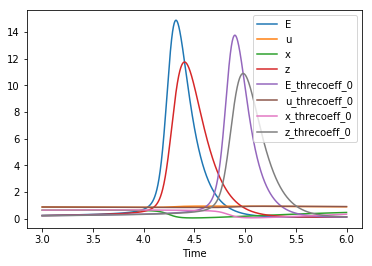

In [7]:
def plot_results_from_data(data_name, data_name_2, plot_dpi, start_time, end_time, output_name):
    plt.clf()
    pp = PdfPages('{}.pdf'.format(output_name))
    #fig = plt.figure(figsize = (40, 30), dpi = plot_dpi)
    fig = plt.figure()
    with h5py.File(data_name) as f:
        loaded_E_t = np.array(f['sim_data/E_t'])
        loaded_x_t = np.array(f['sim_data/x_t'])
        loaded_u_t = np.array(f['sim_data/u_t'])
        loaded_z_t = np.array(f['sim_data/z_t'])
        plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_E_t[int(start_time*(1/dt)):int(end_time*(1/dt))], label="E")
        plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_u_t[int(start_time*(1/dt)):int(end_time*(1/dt))], label="u")
        plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_x_t[int(start_time*(1/dt)):int(end_time*(1/dt))], label="x")
        plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_z_t[int(start_time*(1/dt)):int(end_time*(1/dt))], label="z")
        #plt.plot(time, z_t[:,1], label="threshold")
        with h5py.File(data_name_2) as g:
            loaded_E_t_2 = np.array(g['sim_data/E_t'])
            loaded_x_t_2 = np.array(g['sim_data/x_t'])
            loaded_u_t_2 = np.array(g['sim_data/u_t'])
            loaded_z_t_2 = np.array(g['sim_data/z_t'])
            plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_E_t_2[int(start_time*(1/dt)):int(end_time*(1/dt))], label="E_threcoeff_0")
            plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_u_t_2[int(start_time*(1/dt)):int(end_time*(1/dt))], label="u_threcoeff_0")
            plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_x_t_2[int(start_time*(1/dt)):int(end_time*(1/dt))], label="x_threcoeff_0")
            plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_z_t_2[int(start_time*(1/dt)):int(end_time*(1/dt))], label="z_threcoeff_0")
    plt.legend(loc="upper right")
    plt.xlabel("Time")
    plt.show()
    pp.savefig(fig)
    pp.close()


for i in range(int(memory_reset_timing*(1/dt))-1):
    rk_exuz.time[i+1] = (i+1) *rk_exuz.dt



plot_results_from_data('data/final_100.h5', 'data_2/final_100.h5', 300, 3, 6, 'compar_thre_all')

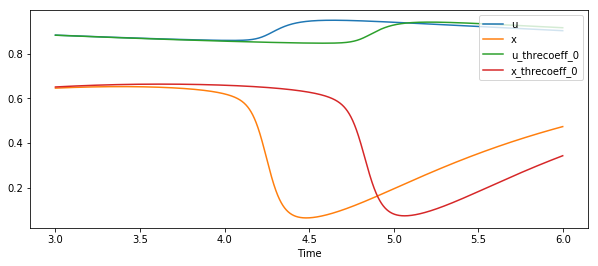

In [7]:
def plot_results_xu_only_from_data(data_name, data_name_2, plot_dpi, start_time, end_time, output_name):
    plt.clf()
    pp = PdfPages('{}.pdf'.format(output_name))
    #fig = plt.figure(figsize = (40, 30), dpi = plot_dpi)
    fig = plt.figure(figsize=(10, 4))
    with h5py.File(data_name) as f:
        loaded_E_t = np.array(f['sim_data/E_t'])
        loaded_x_t = np.array(f['sim_data/x_t'])
        loaded_u_t = np.array(f['sim_data/u_t'])
        loaded_z_t = np.array(f['sim_data/z_t'])
        #plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_E_t[int(start_time*(1/dt)):int(end_time*(1/dt))], label="E")
        plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_u_t[int(start_time*(1/dt)):int(end_time*(1/dt))], label="u")
        plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_x_t[int(start_time*(1/dt)):int(end_time*(1/dt))], label="x")
        #plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_z_t[int(start_time*(1/dt)):int(end_time*(1/dt))], label="z")
        #plt.plot(time, z_t[:,1], label="threshold")
        with h5py.File(data_name_2) as g:
            loaded_E_t_2 = np.array(g['sim_data/E_t'])
            loaded_x_t_2 = np.array(g['sim_data/x_t'])
            loaded_u_t_2 = np.array(g['sim_data/u_t'])
            loaded_z_t_2 = np.array(g['sim_data/z_t'])
            #plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_E_t_2[int(start_time*(1/dt)):int(end_time*(1/dt))], label="E_threcoeff_0")
            plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_u_t_2[int(start_time*(1/dt)):int(end_time*(1/dt))], label="u_threcoeff_0")
            plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_x_t_2[int(start_time*(1/dt)):int(end_time*(1/dt))], label="x_threcoeff_0")
            #plt.plot(rk_exuz.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_z_t_2[int(start_time*(1/dt)):int(end_time*(1/dt))], label="z_threcoeff_0")
    plt.legend(loc="upper right")
    plt.xlabel("Time")
    plt.show()
    pp.savefig(fig)
    pp.close()


for i in range(int(memory_reset_timing*(1/dt))-1):
    rk_exuz.time[i+1] = (i+1) *rk_exuz.dt



plot_results_xu_only_from_data('data/final_100.h5', 'data_2/final_100.h5', 300, 3, 6, 'compar_thre_xu')